# Capstone Project: The Battle of Neighborhoods
## Finding a location for a new bakery in Cincinnati

This notebook presents my capstone project for the Applied Data Science Capstone course in the Coursera IBM Data Science Professional Certificate.

## 1. Data import <a name="data"></a>

#### Import relevant libraries for entire project

In [1]:
# all relevant library imports
import pandas as pd # creating dataframes
import numpy as np # arrays
from bs4 import BeautifulSoup # web scraping
import requests # get URL for web scraping
import urllib.request # web scraping
import re # web scraping
import foursquare # easier access to parts of foursquare API

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline

#### Web scrape Wikipedia data to get Cincinnati neighborhoods

In [2]:
# Scrape wikipedia page of Cincinnati neighborhoods to get names of neighborhoods
r = requests.get('https://en.wikipedia.org/wiki/List_of_Cincinnati_neighborhoods')
soup = BeautifulSoup(r.content)

# extract correct div/section from HTML
contentTable  = soup.find("div", {"class": "navbox"})
# Find the relevant rows in the div based on the title of the html tag
rows  = contentTable.find_all('a', title = re.compile(', Cincinnati$'))
# create the list of neighborhood names
cincy_neigh = []
for row in rows:
    cincy_neigh.append(row.get_text())
    
# remove "The villages of Roll Hill" -- geopy will not be able to find this neighborhood
del cincy_neigh[-6]

#### Extract location data for Cincinnati and Northern Kentucky neighborhoods

In [3]:
geolocator = Nominatim(user_agent="cincy_explorer")

lst = []
# Use geocode to find address and geographic location for each neighborhood
for neigh in cincy_neigh:
    address = neigh + ', Cincinnati, OH'
    location = geolocator.geocode(address)
    print(location)
    lst.append([neigh, location.address, location.latitude, location.longitude])
    
# add in NKY neighborhoods too--just those close to Cincy
nky_neigh = ['Bellevue','Covington','Dayton','Erlanger','Fort Mitchell','Fort Thomas','Latonia','Ludlow','Newport','Park Hills','Southgate','Taylor Mill','Villa Hills','Wilder']
for neigh in nky_neigh:
    address = neigh + ', KY'
    location = geolocator.geocode(address)
    print(location)
    lst.append([neigh, location.address, location.latitude, location.longitude])

Avondale, Cincinnati, Hamilton County, Ohio, 45229-2600, United States of America
Bond Hill, Cincinnati, Hamilton County, Ohio, United States of America
California, Cincinnati, Hamilton County, Ohio, 45228, United States of America
Camp Washington, Cincinnati, Hamilton County, Ohio, United States of America
Carthage, Cincinnati, Hamilton County, Ohio, 45216, United States of America
Clifton, Cincinnati, Hamilton County, Ohio, 45220, United States of America
College Hill, Cincinnati, Hamilton County, Ohio, 45224, United States of America
Columbia-Tusculum, Cincinnati, Hamilton County, Ohio, 45226, United States of America
Corryville, Cincinnati, Hamilton County, Ohio, 45219-2062, United States of America
Clifton Heights–University Heights–Fairview, Cincinnati, Hamilton County, Ohio, United States of America
East End, Cincinnati, Hamilton County, Ohio, United States of America
East Price Hill, Cincinnati, Hamilton County, Ohio, 45204, United States of America
East Walnut Hills, Cincinnat

#### How many neighborhoods are there in total?

In [4]:
len(nky_neigh) + len(cincy_neigh)

60

#### Create data frame from list of neighborhoods, containing geographic coordinates

In [5]:
cd = pd.DataFrame(lst, columns=['Neighborhood','Address','Latitude','Longitude'])
cd.head()

,Neighborhood,Address,Latitude,Longitude
0,Avondale,"Avondale, Cincinnati, Hamilton County, Ohio, 4...",39.147837,-84.494943
1,Bond Hill,"Bond Hill, Cincinnati, Hamilton County, Ohio, ...",39.174781,-84.467164
2,California,"California, Cincinnati, Hamilton County, Ohio,...",39.065206,-84.427239
3,Camp Washington,"Camp Washington, Cincinnati, Hamilton County, ...",39.136982,-84.537168
4,Carthage,"Carthage, Cincinnati, Hamilton County, Ohio, 4...",39.196028,-84.478618


#### Visualize Greater Cincinnati neighborhood locations

In [6]:
address = 'Cincinnati, OH'

geolocator = Nominatim(user_agent="cincy_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Cincinnati are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Cincinnati are 39.1014537, -84.5124602.


In [7]:
# create map of Greater Cincinnati using latitude and longitude values
map_cincy = folium.Map(location=[latitude, longitude], zoom_start=11)
map_cincy

# add markers to map
for lat, lng, label in zip(cd['Latitude'], cd['Longitude'], cd['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
         [lat, lng],
         radius=5,
       popup=label,
        color='blue',
         fill=True,
         fill_color='#3186cc',
         fill_opacity=0.7,
         parse_html=False).add_to(map_cincy)  
    
map_cincy

## 2. Exploratory data analysis of venues, bakery locations, and likes <a name="eda"></a>

#### Initialize API credentials

In [8]:
# values are hidden on github
CLIENT_ID = XXXXXX # your Foursquare ID
CLIENT_SECRET = XXXXXX # your Foursquare Secret
VERSION = XXXXXX # Foursquare API version
LIMIT = 200

In [9]:
# was having difficulty accessing likes, so I found the foursquare library that makes it much easier to do!
client = foursquare.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET,version=VERSION)

#### Define functions to extract Foursquare data

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    '''Extracts popular venues from a given location and returns information about the neighborhood 
        and popular venues in a data frame'''
    # https://developer.foursquare.com/docs/api-reference/venues/explore/
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        radius = requests.get(url).json()["response"]['suggestedRadius']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'], # need to grab venue ID for ratings
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            radius, # what is the suggested radius for each neighborhood?
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Distance',
                  'Radius',
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
def getBakeries(names, latitudes, longitudes, radius):
    
    '''Searches for all venues with "bakery" in the title in a given neighborhood and radius and returns
        results in a data frame'''
    # https://developer.foursquare.com/docs/api-reference/venues/search/
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        #print(name)
            
        latlong = str(lat) + ',' + str(lng)
        
        results = client.venues.search(params={'query': 'bakery', 'll': latlong, 'radius': rad, 'limit': 50})
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            rad,
            v['name'], 
            v['id'], # need to grab venue ID for ratings
            v['location']['lat'], 
            v['location']['lng'],
            v['location']['distance'],
            v['categories'][0]['name'] if v['categories'] else "NaN") for v in results['venues']])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Radius',
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  #'State',
                  'Distance',
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
def getVenueLikes(names, venues, ids):
    
    '''Extracts number of likes for a given venue, defined by the unique Venue ID'''
    # https://developer.foursquare.com/docs/api-reference/venues/likes/
    
    likes_list=[]
    for name, venue, vid in zip(names, venues, ids):
        #print(name + venue + vid)
            
        likes = client.venues.likes(vid)
        
        # return only relevant information for each nearby venue
        likes_list.append([
            name, 
            venue,
            vid, 
            likes['likes']['count']])

    venue_likes = pd.DataFrame(likes_list, columns=['Neighborhood','Venue','Venue ID','Num Likes']) 
    
    return(venue_likes)

#### Explore Cincinnati neighborhood venues

In [13]:
cincy_venues = getNearbyVenues(names=cd['Neighborhood'],
                                   latitudes=cd['Latitude'],
                                   longitudes=cd['Longitude']
                                  )

Avondale
Bond Hill
California
Camp Washington
Carthage
Clifton
College Hill
Columbia-Tusculum
Corryville
CUF
East End
East Price Hill
East Walnut Hills
East Westwood
English Woods
Evanston
Hartwell
Hyde Park
Kennedy Heights
Linwood
Madisonville
Millvale
Mount Adams
Mount Airy
Mount Lookout
Mount Washington
North Avondale
North Fairmount
Northside
Oakley
Paddock Hills
Pendleton
Pleasant Ridge
Queensgate
Riverside
Roselawn
Sayler Park
Sedamsville
South Cumminsville
South Fairmount
Spring Grove Village
Walnut Hills
West End
West Price Hill
Westwood
Winton Hills
Bellevue
Covington
Dayton
Erlanger
Fort Mitchell
Fort Thomas
Latonia
Ludlow
Newport
Park Hills
Southgate
Taylor Mill
Villa Hills
Wilder


#### What are the most common venues in the area?

In [14]:
cincy_venues['Venue Category'].value_counts().head(10)

American Restaurant    366
Pizza Place            268
Bar                    259
Ice Cream Shop         208
Sandwich Place         206
Coffee Shop            189
Park                   149
Mexican Restaurant     134
Brewery                116
Discount Store         106
Name: Venue Category, dtype: int64

#### Take a look at the venues data frame

In [15]:
cincy_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Distance,Radius,Venue Category
0,Avondale,39.147837,-84.494943,Hippo Cove,586432036431e50bfa4c445a,39.145257,-84.506104,1005,2659,Zoo Exhibit
1,Avondale,39.147837,-84.494943,Dobsa Giraffe Ridge,4e15e91852b1b9e56444ab78,39.143495,-84.506975,1145,2659,Zoo Exhibit
2,Avondale,39.147837,-84.494943,Jungle Trails,4c603cbdde6920a145699564,39.146071,-84.506643,1029,2659,Zoo Exhibit
3,Avondale,39.147837,-84.494943,Cincinnati Zoo & Botanical Garden,4b418ab6f964a5206ec725e3,39.142740,-84.509266,1360,2659,Zoo
4,Avondale,39.147837,-84.494943,Marge Schott-Unnewehr Elephant Reserve,4e594b20ae6099fc00c62a34,39.143109,-84.508114,1253,2659,Zoo Exhibit


#### Remove duplicate venues
Because the neighborhood radius is different for each neighborhood, some might overlap and therefore return the same venue in multiple different neighborhoods. To remove duplicates, we want to find venues with the same ID and keep the one that is closest to the neighborhood center (Distance column).

In [16]:
print(len(cincy_venues))  # how many venues are there total?
print(len(cincy_venues['Venue ID'].unique())) # how many venues are unique?

cincy_venues['duplicate'] = cincy_venues['Venue ID'].duplicated() # which venues are duplicates?
cincy_venues.head()

5800
1713


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Distance,Radius,Venue Category,duplicate
0,Avondale,39.147837,-84.494943,Hippo Cove,586432036431e50bfa4c445a,39.145257,-84.506104,1005,2659,Zoo Exhibit,False
1,Avondale,39.147837,-84.494943,Dobsa Giraffe Ridge,4e15e91852b1b9e56444ab78,39.143495,-84.506975,1145,2659,Zoo Exhibit,False
2,Avondale,39.147837,-84.494943,Jungle Trails,4c603cbdde6920a145699564,39.146071,-84.506643,1029,2659,Zoo Exhibit,False
3,Avondale,39.147837,-84.494943,Cincinnati Zoo & Botanical Garden,4b418ab6f964a5206ec725e3,39.142740,-84.509266,1360,2659,Zoo,False
4,Avondale,39.147837,-84.494943,Marge Schott-Unnewehr Elephant Reserve,4e594b20ae6099fc00c62a34,39.143109,-84.508114,1253,2659,Zoo Exhibit,False


In [17]:
# find duplicated venues and keep only the venues with the minimum distance from the neighborhood center
dist_mins = cincy_venues.groupby(['Venue ID']).Distance.transform(min)
cincy_venues2 = cincy_venues.loc[cincy_venues.Distance == dist_mins]

print(len(cincy_venues2))
print(len(cincy_venues2['Venue ID'].unique())) # these should be the same now

1713
1713


In [18]:
# remove all venues with "Bakery" in the title to avoid duplication -- will use separate function to find _all_ bakeries in area
cincy_venues2 = cincy_venues2[~cincy_venues2["Venue"].str.contains("Bakery")]
cincy_venues2.loc[:, 'Is Bakery'] = 0

#### Get neighborhood radius information and merge with neighborhood data

In [19]:
neigh_radius = pd.DataFrame(cincy_venues2.groupby(['Neighborhood']).Radius.mean()).reset_index()

cd2 = cd.merge(neigh_radius, on="Neighborhood")
cd2.head()

,Neighborhood,Address,Latitude,Longitude,Radius
0,Avondale,"Avondale, Cincinnati, Hamilton County, Ohio, 4...",39.147837,-84.494943,2659
1,Bond Hill,"Bond Hill, Cincinnati, Hamilton County, Ohio, ...",39.174781,-84.467164,4083
2,California,"California, Cincinnati, Hamilton County, Ohio,...",39.065206,-84.427239,6229
3,Camp Washington,"Camp Washington, Cincinnati, Hamilton County, ...",39.136982,-84.537168,2461
4,Carthage,"Carthage, Cincinnati, Hamilton County, Ohio, 4...",39.196028,-84.478618,4858


#### Find all bakeries in Greater Cincinnati
Search the term "bakery" in Foursquare to find all potential bakeries -- may not have "Bakery" as venue category.

In [20]:
cincy_bakeries = getBakeries(names=cd2['Neighborhood'],
                             latitudes = cd2['Latitude'],
                             longitudes = cd2['Longitude'],
                             radius=cd2['Radius'])

Remove duplicates as done above

In [21]:
# find duplicated venues and keep only the venues with the minimum distance from the neighborhood center
dist_mins = cincy_bakeries.groupby(['Venue ID']).Distance.transform(min)
cincy_bakeries2 = cincy_bakeries.loc[cincy_bakeries.Distance == dist_mins]

# since category isn't always bakery, add column to indicate that this is a bakery  (ignore warning)
cincy_bakeries2.loc[:, 'Is Bakery'] = 1

print(len(cincy_bakeries2))
print(len(cincy_bakeries2['Venue ID'].unique()))

77
77


/Users/mariafox/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariafox/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [22]:
cincy_bakeries2.to_csv("cincy_bakeries.csv")
cincy_bakeries2.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Radius,Venue,Venue ID,Venue Latitude,Venue Longitude,Distance,Venue Category,Is Bakery
2,Bond Hill,39.174781,-84.467164,4083,Klostermans Bakery Store,4f32838f19836c91c7df3307,39.178004,-84.477245,940,Bakery,1
26,College Hill,39.202280,-84.547167,5340,Perkins Restaurant & Bakery,4b8aaaccf964a5208c7832e3,39.223180,-84.548449,2329,American Restaurant,1
27,College Hill,39.202280,-84.547167,5340,Skally's Old World Bakery,4b8be919f964a520e6b132e3,39.218128,-84.558434,2014,Bakery,1
30,College Hill,39.202280,-84.547167,5340,North College Hill Bakery,4b9b888ef964a520920d36e3,39.218016,-84.553832,1843,Bakery,1
33,College Hill,39.202280,-84.547167,5340,Little Dutch Bakery,5079655ae4b0d3b808987aae,39.233027,-84.548220,3423,Bakery,1


#### Where are the bakeries located in relation to neighborhood centers?

In [23]:
# create map of Toronto using latitude and longitude values
map_cincy = folium.Map(location=[latitude, longitude], zoom_start=11)
map_cincy

# add markers to map
for lat, lng, label in zip(cd['Latitude'], cd['Longitude'], cd['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
         [lat, lng],
         radius=5,
       popup=label,
        color='blue',
         fill=True,
         fill_color='#3186cc',
         fill_opacity=0.7,
         parse_html=False).add_to(map_cincy)  

for lat, lng, label in zip(cincy_bakeries2['Venue Latitude'], cincy_bakeries2['Venue Longitude'], cincy_bakeries2['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
         [lat, lng],
         radius=5,
       popup=label,
        color='red',
         fill=True,
         fill_color='#fffff',
         fill_opacity=0.7,
         parse_html=False).add_to(map_cincy)
    
map_cincy

#### Get number of "likes" for each bakery

In [24]:
cincy_likes = getVenueLikes(names=cincy_bakeries2['Neighborhood'],
                            venues = cincy_bakeries2['Venue'],
                            ids=cincy_bakeries2['Venue ID'])

Which have at least one like?

In [25]:
cincy_likes[cincy_likes['Num Likes'] > 0].sort_values(by='Num Likes',ascending=False)

,Neighborhood,Venue,Venue ID,Num Likes
11,Hyde Park,Busken Bakery,4b51bd94f964a5200e5427e3,67
13,Kennedy Heights,Ferrari's Little Italy and Bakery,4b4dfb7cf964a520ffdc26e3,36
1,College Hill,Perkins Restaurant & Bakery,4b8aaaccf964a5208c7832e3,23
48,Westwood,Perkins Restaurant & Bakery,4ba63fe1f964a520123f39e3,17
28,Pendleton,Brown Bear Bakery,515d1365e4b0d2cd6d15e8e6,16
3,College Hill,North College Hill Bakery,4b9b888ef964a520920d36e3,12
19,Mount Washington,Mt. Washington Creamy Whip,4c1036ef81e976b0ecdd0eeb,12
23,Northside,Bonomini Bakery,4b76ce0ef964a5206b602ee3,12
31,Pendleton,Shadeau Breads,4b489c99f964a520885026e3,10
57,Erlanger,Servatti Pastry Shop & Deli,4b75d6f5f964a52088282ee3,9


Busken Bakery in Hyde Park is by far the most popular bakery, followed by Ferrari's Little Italy and Bakery in Kennedy Heights.

#### Locate the most popular bakeries (>= 10 likes)

In [26]:
# Where are the bakeries with >= 10 likes?
high_like_neigh = cincy_likes[cincy_likes['Num Likes'] > 9].sort_values(by='Num Likes',ascending=False).Neighborhood.unique()
print(high_like_neigh)

['Hyde Park' 'Kennedy Heights' 'College Hill' 'Westwood' 'Pendleton'
 'Mount Washington' 'Northside']


In [27]:
len(high_like_neigh)  # how many neighborhoods have popular bakeries?

7

#### What other businesses are in the neighborhoods with popular bakeries?

In [28]:
cincy_like_neigh = cincy_venues2[cincy_venues2['Neighborhood'].isin(high_like_neigh)] # filter by neighborhoods in high-like list
cincy_like_neigh.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Distance,Radius,Venue Category,duplicate,Is Bakery
564,College Hill,39.20228,-84.547167,College Hill Coffee Co. and Casual Gourmet,4b58920af964a520b95e28e3,39.202948,-84.547559,81,5340,Café,False,0
565,College Hill,39.20228,-84.547167,Chung Ching Restaurant,4b9aec4cf964a52081e335e3,39.198213,-84.546327,458,5340,Chinese Restaurant,False,0
566,College Hill,39.20228,-84.547167,Marty's Hops and Vines,4b58abedf964a520e56428e3,39.202215,-84.547513,30,5340,Wine Bar,False,0
567,College Hill,39.20228,-84.547167,Brink Brewing Company,582df9a7d22e7b483c68f866,39.199001,-84.546955,365,5340,Brewery,False,0
568,College Hill,39.20228,-84.547167,Red Rose,520e956e498e5d0825f0524c,39.199258,-84.547239,336,5340,Italian Restaurant,False,0


In [29]:
# neighborhoods with popular bakeries
map_cincy2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(cincy_like_neigh['Venue Latitude'], cincy_like_neigh['Venue Longitude'], cincy_like_neigh['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
         [lat, lng],
         radius=5,
       popup=label,
        color='blue',
         fill=True,
         fill_color='#3186cc',
         fill_opacity=0.7,
         parse_html=False).add_to(map_cincy2)  
    
map_cincy2

They seem to be pretty well spread around the city--only one neighborhood, Pendleton, is located in downtown Cincinnati. The other neighborhoods are located outside the downtown area. 

#### Summarize the other businesses in each neighborhood with popular bakeries

In [30]:
# How many of each type of venue are located in these neighborhoods?
neigh_counts = cincy_like_neigh.groupby('Neighborhood')['Venue Category'].value_counts().unstack()
neigh_counts = pd.DataFrame(neigh_counts)

# remove categories that only one or two neighborhoods contain
neigh_counts.dropna(axis=1,how='all',thresh=3,inplace=True)
neigh_counts

Venue Category,American Restaurant,Bakery,Bank,Bar,Bookstore,Breakfast Spot,Brewery,Burger Joint,Chinese Restaurant,Coffee Shop,...,Pizza Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Sporting Goods Shop,Sports Bar,Steakhouse,Sushi Restaurant,Video Game Store,Wine Bar
Neighborhood,,,,,,,,,,,,,,,,,,,,,
College Hill,2.0,NaN,3.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,...,3.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Hyde Park,3.0,NaN,NaN,NaN,1.0,1.0,1.0,2.0,2.0,1.0,...,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,2.0
Kennedy Heights,3.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,5.0,2.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
Mount Washington,3.0,3.0,2.0,2.0,NaN,1.0,NaN,1.0,2.0,2.0,...,5.0,3.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN
Northside,1.0,NaN,1.0,5.0,NaN,1.0,1.0,1.0,NaN,2.0,...,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pendleton,4.0,1.0,NaN,11.0,1.0,1.0,3.0,2.0,NaN,4.0,...,1.0,1.0,2.0,NaN,NaN,1.0,2.0,1.0,NaN,1.0
Westwood,8.0,NaN,NaN,2.0,1.0,1.0,2.0,NaN,1.0,2.0,...,5.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN


#### Visualize category counts using a heat map

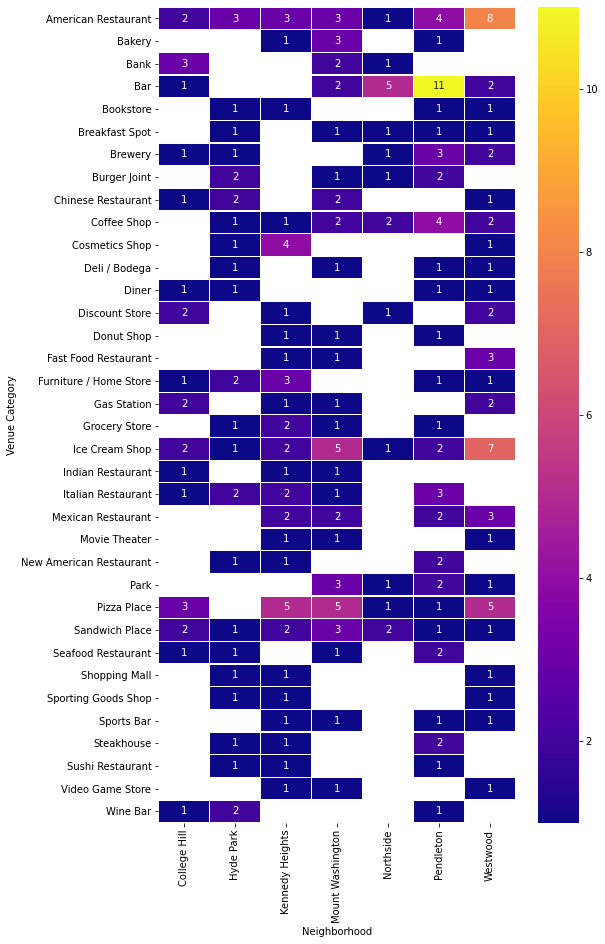

In [31]:
plt.figure(figsize=(8,15))
sns.heatmap(neigh_counts.transpose(), annot=True, linewidths=0.25, cmap='plasma')

There appears to be quite a bit of variability here, but there are a few categories that stand out and are present in all the neighborhoods:
- American restaurant
- Ice cream shop
- Sandwich place
- Pizza place (all but one neighborhood)

#### Visualize category frequencies

In [32]:
# makes more sense to look at frequencies rather than counts?
# one hot encoding
cincy_onehot = pd.get_dummies(cincy_venues2[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cincy_onehot['Neighborhood'] = cincy_venues2['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [cincy_onehot.columns[-1]] + list(cincy_onehot.columns[:-1])
cincy_onehot = cincy_onehot[fixed_columns]

# calculate mean frequency for each neighborhood
cincy_grouped = cincy_onehot.groupby('Neighborhood').mean().reset_index()

In [33]:
# keep only neighborhoods with popular bakeries
cincy_grouped2 = cincy_grouped[cincy_grouped['Neighborhood'].isin(high_like_neigh)].set_index('Neighborhood')
# remove all columns with zeros
cincy_grouped2 = cincy_grouped2.loc[:, cincy_grouped2.any()]

cincy_grouped2

,ATM,Accessories Store,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,...,Toy / Game Store,Venezuelan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,
College Hill,0.000000,0.00,0.064516,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000
Hyde Park,0.000000,0.02,0.060000,0.000000,0.020000,0.000000,0.000000,0.000000,0.02,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000
Kennedy Heights,0.000000,0.00,0.043478,0.000000,0.000000,0.014493,0.000000,0.000000,0.00,0.000000,...,0.014493,0.000000,0.014493,0.000000,0.000000,0.000000,0.000000,0.014493,0.014493,0.014493
Mount Washington,0.017544,0.00,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Northside,0.000000,0.00,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000
Pendleton,0.000000,0.00,0.043956,0.000000,0.010989,0.010989,0.010989,0.000000,0.00,0.021978,...,0.000000,0.010989,0.000000,0.000000,0.010989,0.000000,0.010989,0.000000,0.000000,0.000000
Westwood,0.000000,0.00,0.121212,0.015152,0.000000,0.000000,0.000000,0.015152,0.00,0.000000,...,0.000000,0.000000,0.015152,0.015152,0.000000,0.000000,0.000000,0.000000,0.015152,0.000000


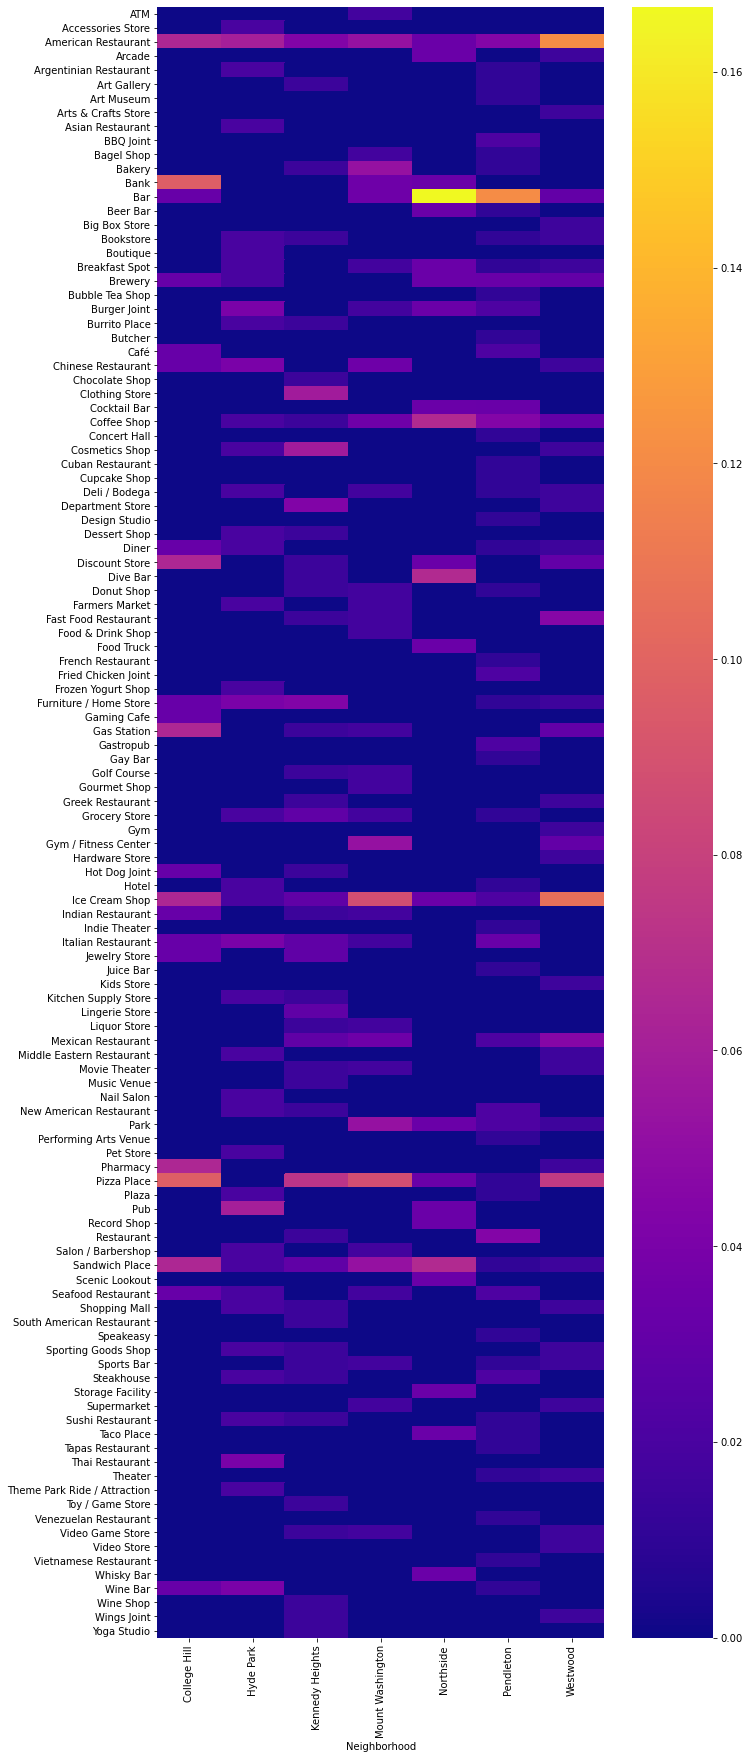

In [34]:
# Visualize mean frequencies in heat map
fig = plt.figure(figsize=(10,30))
sns.heatmap(cincy_grouped2.transpose(), annot=False, cmap='plasma')
fig.savefig('heatmap1.png', bbox_inches='tight')

Shows the same pattern as the figure above: American restaurants, ice cream shops, pizza places, and sandiwch places are prominent locations in these neighborhoods.

## 3. K-Means cluster analysis <a name="kmeans"></a>

#### Merge general venue and bakery venue data

In [35]:
# merge cincy_venues2 and cincy_bakeries2, drop irrelevant columns
cincy_all = pd.concat([cincy_venues2, cincy_bakeries2]).reset_index(drop=True).drop(['duplicate','Venue ID','Radius'],axis=1)
cincy_all.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Distance,Venue Category,Is Bakery
0,Avondale,39.147837,-84.494943,Hippo Cove,39.145257,-84.506104,1005,Zoo Exhibit,0
1,Avondale,39.147837,-84.494943,Dobsa Giraffe Ridge,39.143495,-84.506975,1145,Zoo Exhibit,0
2,Avondale,39.147837,-84.494943,Jungle Trails,39.146071,-84.506643,1029,Zoo Exhibit,0
3,Avondale,39.147837,-84.494943,Cincinnati Children's Hospital Cafeteria,39.140524,-84.501905,1011,Cafeteria,0
4,Avondale,39.147837,-84.494943,Kroger Lords of the Arctic,39.145949,-84.507424,1097,Zoo Exhibit,0


In [36]:
# do one-hot coding on whole data frame to get dummies for each category
cincy_onehot = pd.get_dummies(cincy_all[['Venue Category']], prefix="", prefix_sep="")

cincy_all2 = pd.concat([cincy_all.drop('Venue Category',axis=1),cincy_onehot], axis=1)
# remove "Bakery" category -- using a broader definition of bakery here, so "Is Bakery" is more relevant column
cincy_all2.drop(['Bakery'],axis=1,inplace=True)
cincy_all2.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Distance,Is Bakery,ATM,Accessories Store,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Avondale,39.147837,-84.494943,Hippo Cove,39.145257,-84.506104,1005,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Avondale,39.147837,-84.494943,Dobsa Giraffe Ridge,39.143495,-84.506975,1145,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Avondale,39.147837,-84.494943,Jungle Trails,39.146071,-84.506643,1029,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Avondale,39.147837,-84.494943,Cincinnati Children's Hospital Cafeteria,39.140524,-84.501905,1011,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Avondale,39.147837,-84.494943,Kroger Lords of the Arctic,39.145949,-84.507424,1097,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Calculate average frequencies

In [37]:
cincy_grouped3 = cincy_all2.groupby('Neighborhood').mean().reset_index()

#cincy_grouped3.loc[cincy_grouped3['Is Bakery']>0, 'Has Bakery'] = 1
#cincy_grouped3.loc[cincy_grouped3['Is Bakery']==0, 'Has Bakery'] = 0

cincy_grouped3.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Distance,Is Bakery,ATM,Accessories Store,Airport,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Avondale,39.147837,-84.494943,39.137477,-84.495754,1689.071429,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.357143
1,Bellevue,39.106708,-84.482648,39.104559,-84.484418,664.055556,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,Bond Hill,39.174781,-84.467164,39.169386,-84.456690,1617.909091,0.090909,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,CUF,39.130350,-84.529351,39.132852,-84.517797,1327.076923,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.025641,0.0,0.0,0.0,0.000000
4,California,39.065206,-84.427239,39.075193,-84.411477,4048.531250,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


#### Create data frame for K-Means clustering

Drop location and distance data--we don't want the location values to influence the clustering; should be based entirely on venue category frequencies.

I decided to leave the "Is Bakery" category in for the cluster analysis, because neighborhoods without bakeries present might belong to the same cluster as neighborhoods with bakeries, and these would suggest good candidates for the new bakery location.

In [38]:
X = cincy_grouped3.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude','Distance'],axis=1)
X.head()

,Is Bakery,ATM,Accessories Store,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.357143
1,0.000000,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.090909,0.0,0.0,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.0,0.0,0.0,0.051282,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.025641,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.0,0.0,0.093750,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


#### Calculate optimal clusters by minimizing WSS

In [39]:
# try another method using wcss  https://jtemporal.com/kmeans-and-elbow-method/
import math 

def calculate_wcss(data):
        wcss = []
        for n in range(2, 15): # limit to 15 potential clusters
            kmeans = KMeans(n_clusters=n, random_state=0) # set random state to make results more repeatable
            kmeans.fit(X=data)
            wcss.append(kmeans.inertia_)
    
        return wcss

def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

# calculating the within clusters sum-of-squares for 19 cluster amounts
sum_of_squares = calculate_wcss(X)
    
# calculating the optimal number of clusters
n = optimal_number_of_clusters(sum_of_squares)
n

8

#### Run K-Means

In [40]:
# run k-means clustering
kmeans = KMeans(n_clusters=n, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 0, 0, 5, 5, 0, 1, 0], dtype=int32)

#### Add K-Means results to mean frequency data frame

In [41]:
cincy_grouped3 = cincy_all2.groupby('Neighborhood').mean().reset_index()

# add clustering labels
cincy_grouped3.insert(0, 'Cluster Labels', kmeans.labels_)
cincy_grouped3.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Distance,Is Bakery,ATM,Accessories Store,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,Avondale,39.147837,-84.494943,39.137477,-84.495754,1689.071429,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.357143
1,0,Bellevue,39.106708,-84.482648,39.104559,-84.484418,664.055556,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,1,Bond Hill,39.174781,-84.467164,39.169386,-84.456690,1617.909091,0.090909,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0,CUF,39.130350,-84.529351,39.132852,-84.517797,1327.076923,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.025641,0.0,0.0,0.0,0.000000
4,0,California,39.065206,-84.427239,39.075193,-84.411477,4048.531250,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


#### Visualize neighborhood clusters

In [42]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n)
ys = [i + x + (i*x)**2 for i in range(n)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cincy_grouped3['Neighborhood Latitude'], cincy_grouped3['Neighborhood Longitude'], cincy_grouped3['Neighborhood'], cincy_grouped3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine cluster members

**How many neighborhoods belong to each cluster?**

In [43]:
cincy_grouped3.groupby('Cluster Labels')['Neighborhood'].count()

Cluster Labels
0    34
1    17
2     2
3     1
4     1
5     3
6     1
7     1
Name: Neighborhood, dtype: int64

Clusters 0 and 1 include the vast majority of neighborhoods.

**What are the most common venue categories in each cluster?**

In [44]:
cincy_long = cincy_grouped3.drop(['Distance','Venue Latitude','Venue Longitude'],axis=1).reset_index()
cincy_long = pd.melt(cincy_long, id_vars=['Cluster Labels','Neighborhood','Neighborhood Latitude','Neighborhood Longitude'])
# remove index rows
cincy_long = cincy_long[~cincy_long.variable.str.contains("index")]

In [45]:
# calculate average frequencies in each cluster
freqs = cincy_long.groupby(['Cluster Labels','variable'])['value'].mean().reset_index()
freqs.sort_values(['value'],ascending=False,inplace=True)

In [46]:
# print venue categories for each cluster with frequencies > 0.025
for cluster in range(0,n):
    print(freqs[(freqs['Cluster Labels'] == cluster) & (freqs['value'] > 0.025)])

     Cluster Labels             variable     value
3                 0  American Restaurant  0.048290
17                0                  Bar  0.047960
50                0          Coffee Shop  0.041473
170               0          Pizza Place  0.038284
166               0                 Park  0.037397
186               0       Sandwich Place  0.031605
148               0   Mexican Restaurant  0.030109
127               0       Ice Cream Shop  0.029365
     Cluster Labels              variable     value
246               1   American Restaurant  0.082552
413               1           Pizza Place  0.080337
375               1             Is Bakery  0.070069
370               1        Ice Cream Shop  0.055170
429               1        Sandwich Place  0.053478
412               1              Pharmacy  0.037303
314               1        Discount Store  0.033993
328               1  Fast Food Restaurant  0.027603
391               1    Mexican Restaurant  0.025471
     Cluster Labels  

#### In which clusters are the popular bakery neighborhoods located?

In [47]:
# which clusters are "high like neighborhoods" in?
cincy_grouped3[cincy_grouped3['Neighborhood'].isin(high_like_neigh)].set_index('Neighborhood')

,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Distance,Is Bakery,ATM,Accessories Store,Airport,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
Neighborhood,,,,,,,,,,,,,,,,,,,,,
College Hill,1,39.202280,-84.547167,39.218479,-84.549809,1959.888889,0.138889,0.000000,0.000000,0.0,...,0.0,0.000000,0.027778,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
Hyde Park,0,39.139596,-84.442397,39.144756,-84.443682,657.627451,0.019608,0.000000,0.019608,0.0,...,0.0,0.000000,0.039216,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
Kennedy Heights,0,39.185615,-84.408274,39.199194,-84.382197,2804.069444,0.041667,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.013889,0.0,0.013889,0.0,0.013889,0.0,0.0
Mount Washington,1,39.087561,-84.386329,39.080515,-84.352781,3482.442623,0.065574,0.016393,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
Northside,0,39.163418,-84.539874,39.161893,-84.540213,417.636364,0.090909,0.000000,0.000000,0.0,...,0.0,0.030303,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
Pendleton,0,39.110500,-84.507756,39.108368,-84.512765,598.863158,0.042105,0.000000,0.000000,0.0,...,0.0,0.000000,0.010526,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
Westwood,1,39.148670,-84.599389,39.149800,-84.620409,2223.757143,0.057143,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.014286,0.0,0.000000,0.0,0.0


There are two clusters that contain the popular bakery neighborhoods: clusters 0 and 1.

# 4. Identify candidate neighborhoods for new location

#### Let's look more closely at clusters 0 and 1

In [48]:
# print venue categories for each cluster with frequencies > 0.025
for cluster in (0,1):
    print(freqs[(freqs['Cluster Labels'] == cluster) & (freqs['value'] > 0.025)])

     Cluster Labels             variable     value
3                 0  American Restaurant  0.048290
17                0                  Bar  0.047960
50                0          Coffee Shop  0.041473
170               0          Pizza Place  0.038284
166               0                 Park  0.037397
186               0       Sandwich Place  0.031605
148               0   Mexican Restaurant  0.030109
127               0       Ice Cream Shop  0.029365
     Cluster Labels              variable     value
246               1   American Restaurant  0.082552
413               1           Pizza Place  0.080337
375               1             Is Bakery  0.070069
370               1        Ice Cream Shop  0.055170
429               1        Sandwich Place  0.053478
412               1              Pharmacy  0.037303
314               1        Discount Store  0.033993
328               1  Fast Food Restaurant  0.027603
391               1    Mexican Restaurant  0.025471


Cluster results show very similar patterns as observed in the heat maps--high frequencies of American restuarants, bars, coffee shops, pizza places, sandwich places, and ice cream shops.

In [49]:
# Extract candidate neighborhoods, i.e. neighborhoods in the same clusters as the neighborhoods with popular bakeries
cand_neigh = cincy_grouped3[(cincy_grouped3['Cluster Labels'] == 0) | (cincy_grouped3['Cluster Labels'] == 1)]

# remove categories with 0 frequencies
cand_neigh.dropna(axis=1,how='all',inplace=True)
cand_neigh.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude','Distance'],axis=1,inplace=True)
cand_neigh.head() # ignore warnings

/Users/mariafox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/mariafox/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Cluster Labels,Neighborhood,Is Bakery,ATM,Accessories Store,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,Avondale,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.357143
1,0,Bellevue,0.000000,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,1,Bond Hill,0.090909,0.0,0.0,0.0,0.181818,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0,CUF,0.000000,0.0,0.0,0.0,0.051282,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.025641,0.0,0.0,0.0,0.000000
4,0,California,0.000000,0.0,0.0,0.0,0.093750,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [50]:
cand_neigh_mn = cand_neigh.groupby('Cluster Labels').mean().transpose()
cand_neigh_mn.head()

Cluster Labels,0,1
Is Bakery,0.019369,0.070069
ATM,0.004823,0.017134
Accessories Store,0.000577,0.000000
Airport,0.001225,0.000000
American Restaurant,0.048290,0.082552


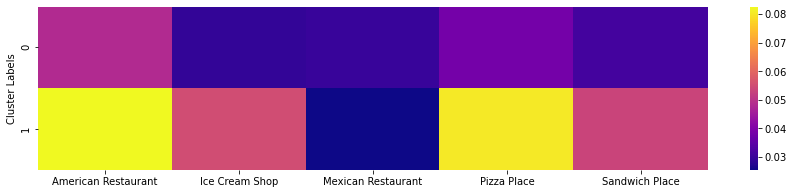

In [51]:
fig = plt.figure(figsize=(15,3))
sns.heatmap(cand_neigh_mn[(cand_neigh_mn[0] > 0.025) & (cand_neigh_mn[1] > 0.025)].transpose(), annot=False, cmap='plasma')
fig.savefig('heatmap2.png', bbox_inches='tight')

Again, we can see here that the clusters differ slighly from one another, but both have large frequencies of American restaurants. Cluster 1 has higher frequencies of bakeries, ice cream shops, pizza places, and sandwich places.

Which neighborhoods are in Clusters 0 and 1?

In [52]:
cincy_grouped3[(cincy_grouped3['Cluster Labels'] == 0) | (cincy_grouped3['Cluster Labels'] == 1)]['Neighborhood']

0                 Avondale
1                 Bellevue
2                Bond Hill
3                      CUF
4               California
7                  Clifton
8             College Hill
9        Columbia-Tusculum
10              Corryville
11               Covington
13                East End
14         East Price Hill
15       East Walnut Hills
16           East Westwood
18                Erlanger
19                Evanston
20           Fort Mitchell
21             Fort Thomas
22                Hartwell
23               Hyde Park
24         Kennedy Heights
25                 Latonia
26                 Linwood
28            Madisonville
30             Mount Adams
31              Mount Airy
32           Mount Lookout
33        Mount Washington
34                 Newport
35          North Avondale
36         North Fairmount
37               Northside
38                  Oakley
39           Paddock Hills
40              Park Hills
41               Pendleton
42          Pleasant Ridge
4

Which of these neighborhoods do **__not__** already have popular bakeries?

In [53]:
cluster0 = cincy_grouped3[(cincy_grouped3['Cluster Labels'] == 0) & (~cincy_grouped3['Neighborhood'].isin(high_like_neigh))]
cluster0.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Distance,Is Bakery,ATM,Accessories Store,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,Avondale,39.147837,-84.494943,39.137477,-84.495754,1689.071429,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.357143
1,0,Bellevue,39.106708,-84.482648,39.104559,-84.484418,664.055556,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
3,0,CUF,39.130350,-84.529351,39.132852,-84.517797,1327.076923,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.025641,0.0,0.000000,0.000000,0.000000
4,0,California,39.065206,-84.427239,39.075193,-84.411477,4048.531250,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
7,0,Clifton,39.144952,-84.520226,39.135559,-84.517252,1214.568966,0.0,0.017241,0.0,...,0.0,0.0,0.017241,0.0,0.0,0.000000,0.0,0.017241,0.017241,0.086207


In [54]:
cluster1 = cincy_grouped3[(cincy_grouped3['Cluster Labels'] == 1) & (~cincy_grouped3['Neighborhood'].isin(high_like_neigh))]
cluster1.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Distance,Is Bakery,ATM,Accessories Store,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
2,1,Bond Hill,39.174781,-84.467164,39.169386,-84.456690,1617.909091,0.090909,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,1,East Price Hill,39.110059,-84.563833,39.113123,-84.585109,2259.608696,0.043478,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,1,East Walnut Hills,39.129543,-84.477040,39.133389,-84.472514,1037.916667,0.000000,0.083333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,1,Erlanger,39.016727,-84.600777,39.015553,-84.605461,2407.827957,0.096774,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,1,Hartwell,39.210817,-84.472761,39.223049,-84.461695,3972.657895,0.078947,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
map_cincy3 = folium.Map(location=[latitude, longitude], zoom_start=11)
map_cincy3

# add markers to map
for lat, lng, label in zip(cluster0['Neighborhood Latitude'], cluster0['Neighborhood Longitude'], cluster0['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
         [lat, lng],
         radius=5,
       popup=label,
        color='blue',
         fill=True,
         fill_color='#3186cc',
         fill_opacity=0.7,
         parse_html=False).add_to(map_cincy3)  

for lat, lng, label in zip(cluster1['Neighborhood Latitude'], cluster1['Neighborhood Longitude'], cluster1['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
         [lat, lng],
         radius=5,
       popup=label,
        color='red',
         fill=True,
         fill_color='#fffff',
         fill_opacity=0.7,
         parse_html=False).add_to(map_cincy3)
    
map_cincy3

#### What are the most characteristic features of these neighborhoods (again)?

In [56]:
pop_neigh = cincy_grouped2.transpose() #.replace(0,np.NaN)
pop_neigh['mean'] = pop_neigh.mean(axis=1)

# filter out venue categories where row means are < 0.025
pop_neigh = pop_neigh[pop_neigh['mean']>0.025].sort_values(['mean'],ascending=False)
pop_neigh

Neighborhood,College Hill,Hyde Park,Kennedy Heights,Mount Washington,Northside,Pendleton,Westwood,mean
American Restaurant,0.064516,0.06,0.043478,0.052632,0.033333,0.043956,0.121212,0.059875
Bar,0.032258,0.00,0.000000,0.035088,0.166667,0.120879,0.030303,0.055028
Pizza Place,0.096774,0.00,0.072464,0.087719,0.033333,0.010989,0.075758,0.053862
Ice Cream Shop,0.064516,0.02,0.028986,0.087719,0.033333,0.021978,0.106061,0.051799
Sandwich Place,0.064516,0.02,0.028986,0.052632,0.066667,0.010989,0.015152,0.036991
Coffee Shop,0.000000,0.02,0.014493,0.035088,0.066667,0.043956,0.030303,0.030072


#### Which other neighborhoods in clusters 0 and 1 have the most similar feature set?

In [57]:
pop_list = ['Neighborhood','American Restaurant','Bar','Pizza Place','Ice Cream Shop','Sandwich Place','Coffee Shop']

In [58]:
cluster0_pop = cluster0[pop_list].transpose()
cluster0_pop.columns = cluster0_pop.iloc[0]
cluster0_pop.drop(cluster0_pop.index[0],inplace=True)
cluster0_pop

Neighborhood,Avondale,Bellevue,CUF,California,Clifton,Columbia-Tusculum,Corryville,Covington,East End,East Westwood,...,Oakley,Paddock Hills,Park Hills,Pleasant Ridge,Queensgate,Southgate,Walnut Hills,West End,Wilder,Winton Hills
American Restaurant,0,0.0555556,0.0512821,0.09375,0.0344828,0.117647,0,0.0555556,0.0833333,0,...,0,0,0,0.0625,0.0333333,0.0333333,0.157895,0,0,0.0526316
Bar,0,0,0.0769231,0.03125,0.0517241,0.117647,0,0.125,0,0,...,0.0392157,0,0.1,0,0,0.0666667,0.157895,0.0344828,0.0416667,0.0789474
Pizza Place,0,0.0555556,0.0769231,0.03125,0.0517241,0.0588235,0.0816327,0.0277778,0,0.0625,...,0.0588235,0,0.1,0,0.0333333,0.0666667,0,0.0344828,0,0.0789474
Ice Cream Shop,0.0714286,0,0.025641,0.03125,0.0172414,0.0588235,0.0612245,0,0,0,...,0.0784314,0,0,0.0625,0,0.0333333,0,0,0.0416667,0.0526316
Sandwich Place,0,0,0.025641,0.03125,0.0517241,0,0.0204082,0.0138889,0,0.0625,...,0.0392157,0.111111,0.1,0.0625,0.0666667,0.0333333,0.0526316,0,0.0416667,0.0263158
Coffee Shop,0.0714286,0.0555556,0.0769231,0.03125,0,0.0588235,0.0816327,0.0416667,0,0,...,0.0588235,0,0,0,0.0333333,0.0666667,0,0.0344828,0.0833333,0.0263158


In [59]:
# get mean frequencies for Cluster 0
cluster0_pop.mean(axis=1)

American Restaurant    0.048966
Bar                    0.045445
Pizza Place            0.039713
Ice Cream Shop         0.029989
Sandwich Place         0.031868
Coffee Shop            0.042463
dtype: float64

In [60]:
cluster1_pop = cluster1[pop_list].transpose()
cluster1_pop.columns = cluster1_pop.iloc[0]
cluster1_pop.drop(cluster1_pop.index[0],inplace=True)
cluster1_pop

Neighborhood,Bond Hill,East Price Hill,East Walnut Hills,Erlanger,Hartwell,Latonia,Mount Airy,Riverside,Roselawn,Sayler Park,Spring Grove Village,Taylor Mill,Villa Hills,West Price Hill
American Restaurant,0.181818,0.0869565,0.0833333,0.0645161,0.0526316,0.0930233,0.142857,0.0833333,0,0.0454545,0.08,0.111111,0.0869565,0.030303
Bar,0,0,0.0833333,0.0107527,0.0263158,0,0,0.0208333,0,0,0,0,0,0.030303
Pizza Place,0.0909091,0.0869565,0.25,0.0430108,0.0789474,0.0697674,0.0571429,0.0416667,0.0857143,0.136364,0.04,0.0444444,0.0434783,0.0606061
Ice Cream Shop,0,0.130435,0,0.0215054,0.0789474,0.0930233,0.0571429,0.0833333,0.0285714,0.0681818,0.04,0.0222222,0,0.0606061
Sandwich Place,0,0,0,0.0430108,0.0526316,0.0465116,0.0571429,0.145833,0.0285714,0.0909091,0.08,0.111111,0.0434783,0.0909091
Coffee Shop,0,0.0434783,0,0.0215054,0,0,0,0,0.0285714,0.0227273,0.04,0.0222222,0,0


In [61]:
# get mean frequencies for Cluster 1
cluster1_pop.mean(axis=1)

American Restaurant    0.081592
Bar                    0.012253
Pizza Place            0.080643
Ice Cream Shop         0.048855
Sandwich Place         0.056436
Coffee Shop            0.012750
dtype: float64

# 5. Finalize new bakery candidates

In [62]:
# calculate euclidean distance between neighborhoods to find most similar ones to cluster 0
clust0_dist = cluster0_pop.apply(lambda x : np.linalg.norm(pd.Series(x) - pd.Series(pop_neigh['mean'])), axis=0).sort_values()

In [63]:
# calculate euclidean distance between neighborhoods to find most similar ones to cluster 1
clust1_dist = cluster1_pop.apply(lambda x : np.linalg.norm(pd.Series(x) - pd.Series(pop_neigh['mean'])), axis=0).sort_values()

In [64]:
# combine and sort cluster distances -- find 5 candidates with lowest distance
clust_dist = clust0_dist.append(clust1_dist)

# print five best candidates
clust_dist.sort_values().head()

Neighborhood
Winton Hills    0.037184
California      0.051777
Southgate       0.051936
Newport         0.054125
Clifton         0.054552
dtype: float64

The five neighborhoods that represent the best candidates for the new bakery are shown above.

In [65]:
neigh_candidates = ['Winton Hills','California','Southgate','Newport','Clifton']

cincy_grouped3[cincy_grouped3['Neighborhood'].isin(neigh_candidates)]

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Distance,Is Bakery,ATM,Accessories Store,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
4,0,California,39.065206,-84.427239,39.075193,-84.411477,4048.531250,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
7,0,Clifton,39.144952,-84.520226,39.135559,-84.517252,1214.568966,0.000000,0.017241,0.0,...,0.0,0.0,0.017241,0.000000,0.0,0.000000,0.0,0.017241,0.017241,0.086207
34,0,Newport,39.088947,-84.491952,39.090588,-84.488169,811.913793,0.034483,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.017241,0.0,0.000000,0.000000,0.000000
50,0,Southgate,39.072005,-84.472720,39.074029,-84.469609,1947.900000,0.033333,0.066667,0.0,...,0.0,0.0,0.000000,0.033333,0.0,0.000000,0.0,0.000000,0.000000,0.000000
59,0,Winton Hills,39.209184,-84.519207,39.224634,-84.520020,1906.815789,0.000000,0.026316,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.052632,0.0,0.000000,0.000000,0.000000


What bakeries are in Newport and Southgate?

In [66]:
cincy_bakeries2[(cincy_bakeries2['Neighborhood'] == 'Newport') | (cincy_bakeries2['Neighborhood'] == 'Southgate')]

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Radius,Venue,Venue ID,Venue Latitude,Venue Longitude,Distance,Venue Category,Is Bakery
369,Newport,39.088947,-84.491952,2100,Cookie Jar Bakery,4b45fe9ef964a520c41326e3,39.088074,-84.489373,243,Bakery,1
370,Newport,39.088947,-84.491952,2100,Mrs Fields Bakery Cafe,4f32555f19836c91c7cd72ea,39.093990,-84.496179,669,Bakery,1
387,Southgate,39.072005,-84.472719,3927,Hostess Bakery Outlets,4f3290ac19836c91c7e43109,39.080498,-84.481177,1194,Bakery,1


## These five neighborhoods represent the best candidate locations for the new bakery. All options were from cluster 0. Only two neighborhoods, Newport and Southgate, already have bakeries.

In [67]:
# Final neighborhood candidates
final_candidates = cincy_grouped3[cincy_grouped3['Neighborhood'].isin(neigh_candidates)]
high_like = cincy_grouped3[cincy_grouped3['Neighborhood'].isin(high_like_neigh)]

map_cincy4 = folium.Map(location=[latitude, longitude], zoom_start=11)
map_cincy4

# add markers to map
for lat, lng, label in zip(final_candidates['Neighborhood Latitude'], final_candidates['Neighborhood Longitude'], final_candidates['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
         [lat, lng],
         radius=10,
       popup=label,
        color='blue',
         fill=True,
         fill_color='#3186cc',
         fill_opacity=0.7,
         parse_html=False).add_to(map_cincy4)  
    
for lat, lng, label in zip(high_like['Neighborhood Latitude'], high_like['Neighborhood Longitude'], high_like['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
         [lat, lng],
         radius=7,
       popup=label,
        color='red',
         fill=True,
         fill_color='red',
         fill_opacity=0.3,
         parse_html=False).add_to(map_cincy4)  
    
map_cincy4